In [1]:
%%capture
!pip install matplotlib numpy pandas seaborn scikit-learn ipython
!pip install --upgrade kneed

In [2]:
import numpy as np  # For numerical operations
import math as mt  # For mathematical functions
import pandas as pd  # For data manipulation
import random  # For random number generation
import matplotlib.pyplot as plt  # For plotting
from sklearn.metrics import silhouette_score  # For evaluating clustering performance
from sklearn.preprocessing import StandardScaler  # For data normalization
from pprint import pprint  # For pretty-printing data structures


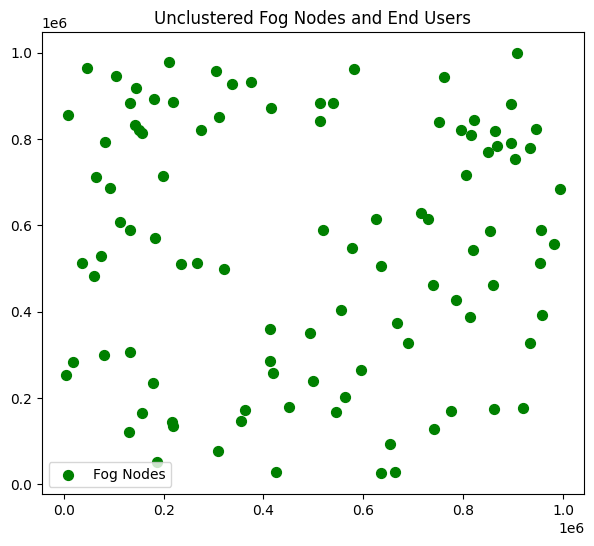

In [3]:
import math as mt
from queue import PriorityQueue

# Class definitions
class SDN:
    def __init__(self, index, x, y, CPUcyc):
        self.id = index
        self.x = x
        self.y = y
        self.tasks_incoming = []
        self.tasks_priority_queue = PriorityQueue()
        self.fcfs_queue = PriorityQueue()
        self.sjf_queue = PriorityQueue()
        self.list_of_fns = []
        self.list_of_eus = []
        self.CPUcyc = CPUcyc

class FN:
    def __init__(self, index, x, y, freq, CPUcyc, failrate):
        self.id = index
        self.x = x
        self.y = y
        self.sdn_num = None
        self.freq = freq
        self.CPUcyc = CPUcyc
        self.failrate = failrate

class EU:
    def __init__(self, index, x, y):
        self.id = index
        self.x = x
        self.y = y
        self.sdn_num = None
        self.tasks = []

# Constants
N = 5000  # Number of end users
M = 100   # Number of fog nodes

# Lists
fns = []  # List of all fog nodes
fns_pos = []  # Positions of fog nodes
eus = []  # List of all end users
eus_pos = []  # Positions of end users

# Failure rate calculation for fog nodes using a Poisson distribution
def computeFailRate():
    _lambda = 25
    p = random.random()
    return -(mt.log(1.0 - p) / _lambda)

# Initialize fog nodes with random attributes
for i in range(M):
    x, y = random.random() * 1000000, random.random() * 1000000
    freq, CPUcyc = random.randint(1, 15), random.randint(500, 1000)
    failrate = computeFailRate()
    fns.append(FN(i, x, y, freq, CPUcyc, failrate))
    fns_pos.append([x, y])

# Initialize end users with random positions
for i in range(N):
    x, y = random.random() * 1000000, random.random() * 1000000
    eus.append(EU(i, x, y))
    eus_pos.append([x, y])

# Plotting
plt.figure(figsize=(7, 6), facecolor='white')
fn_np = np.array(fns_pos)
eu_np = np.array(eus_pos)
plt.scatter(fn_np[:, 0], fn_np[:, 1], color='green', marker='o', s=50, label='Fog Nodes')
# plt.scatter(eu_np[:, 0], eu_np[:, 1], color='blue', marker='o', s=10, label='End Users')
plt.title('Unclustered Fog Nodes and End Users')
plt.legend()
plt.show()

Optimal number of clusters (Elbow Method): 4


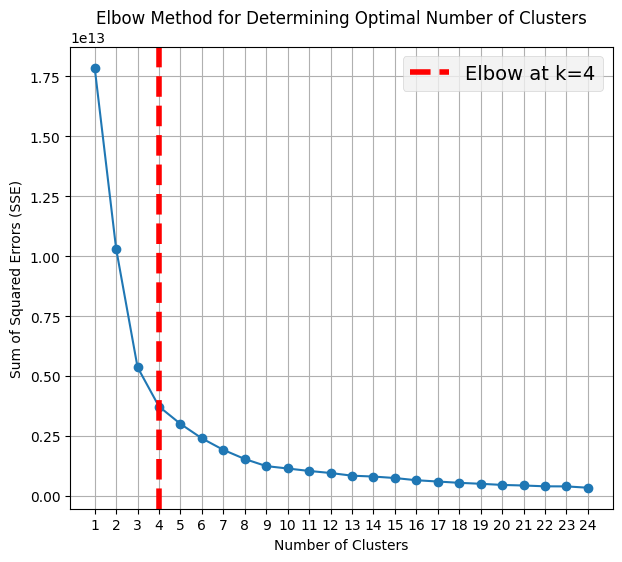

In [4]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import numpy as np

# Settings and variables
max_clusters = int(M / 4)  # Reduce the number of clusters to a quarter of the number of nodes
sse = []  # List to hold the sum of squared errors for each k value

# Perform K-means clustering for a range of cluster counts to find the elbow
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(fn_np)  # Assuming fn_np is your array of fog node positions
    sse.append(kmeans.inertia_)  # Append the sum of squared errors

# Plotting the SSE to find the elbow
plt.figure(figsize=(7, 6))
plt.plot(range(1, max_clusters), sse, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.xticks(range(1, max_clusters))
plt.style.use("fivethirtyeight")

# Identifying the elbow point using KneeLocator
kl = KneeLocator(range(1, max_clusters), sse, curve='convex', direction='decreasing')
elbow_point = kl.elbow
print(f"Optimal number of clusters (Elbow Method): {elbow_point}")

# Highlight the elbow point on the plot
if elbow_point is not None:
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow at k={elbow_point}')
    plt.legend()

plt.show()

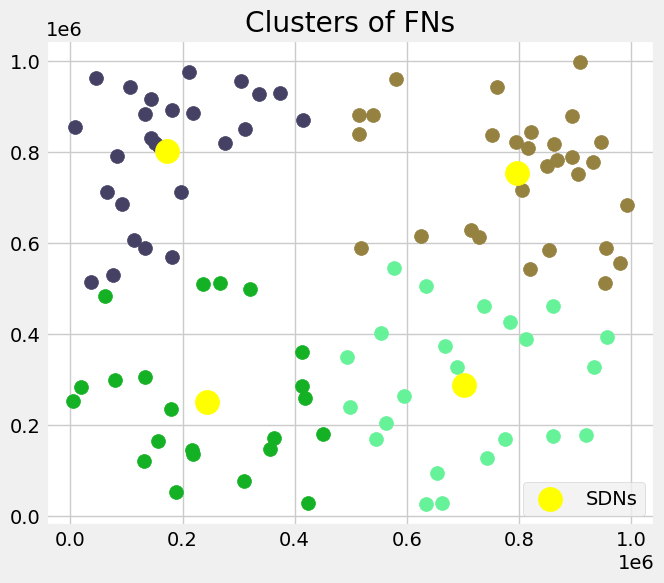

In [5]:
from sklearn.cluster import KMeans
from kneed import KneeLocator  # For finding the knee point in curves

# Assuming fn_np is previously defined and kl.elbow was calculated correctly
kmeans = KMeans(
    init="random",
    n_clusters=kl.elbow,
    n_init=10,
    max_iter=300,
    random_state=42
)
y_predict = kmeans.fit_predict(fn_np)

# Create a figure and axis for the plot with specific size
fig, ax = plt.subplots(figsize=(7, 6))  # Set figure size to 7x6 inches
ax.set_facecolor("white")

# Plot each cluster with a unique color
colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for _ in range(kl.elbow)]
for i in range(kl.elbow):
    ax.scatter(fn_np[y_predict == i, 0], fn_np[y_predict == i, 1], s=100, c=colors[i])

# Plot the cluster centers
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='SDNs')
ax.set_title('Clusters of FNs')
ax.legend()
plt.show()

In [6]:
sdns = [] # list of all sdns
# Initialize SDNs based on cluster centers
for ind, center in enumerate(kmeans.cluster_centers_):
    CPUcyc = random.randint(1000, 2000)  # Randomly assign CPU cycles between 1000 and 2000
    sdns.append(SDN(ind, center[0], center[1], CPUcyc))  # Append new SDN to the list

# Assign each fog node to the nearest SDN and record this in both FN and SDN objects
for fn_num, sdn_num in enumerate(y_predict):
    sdns[sdn_num].list_of_fns.append(fns[fn_num])  # Append FN to the SDN's list of FNs
    fns[fn_num].sdn_num = sdn_num  # Set the FN's assigned SDN number

# Create a DataFrame from SDN data
sdn_data = {
    "ID": [sdn.id for sdn in sdns],
    "X Position": [f"{sdn.x:.2f}" for sdn in sdns],
    "Y Position": [f"{sdn.y:.2f}" for sdn in sdns],
    "CPU Cycles": [sdn.CPUcyc for sdn in sdns],
    "Connected FNs": [len(sdn.list_of_fns) for sdn in sdns],
    "Connected EUs": [len(sdn.list_of_eus) for sdn in sdns]
}
df = pd.DataFrame(sdn_data)
print(df.to_string(index=False))  # Use to_string to print without the default index

 ID X Position Y Position  CPU Cycles  Connected FNs  Connected EUs
  0  172936.08  802430.81        1648             26              0
  1  796894.35  753603.86        1181             29              0
  2  702469.34  288603.13        1005             23              0
  3  243626.68  250504.44        1508             22              0


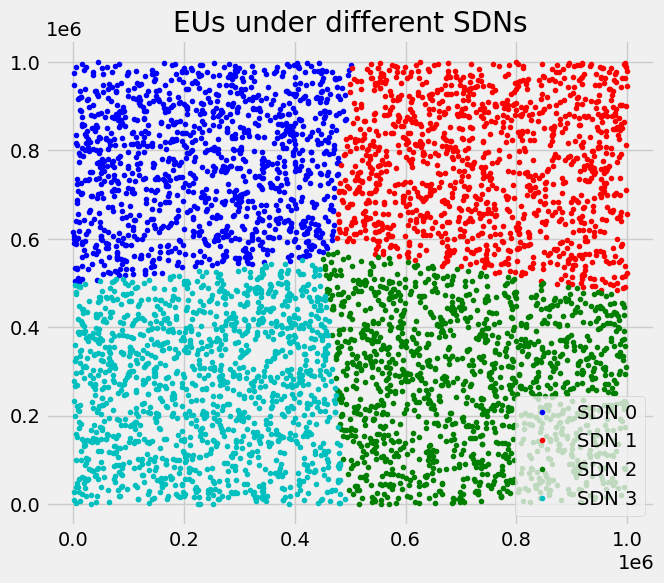

In [7]:
# Initialize a dictionary to track closest SDN for each EU
Co = {}
# Compute distances and determine closest SDN
for i in range(N):
    Co[i] = []
    for j in range(len(sdns)):
        d = mt.sqrt((eus[i].x - sdns[j].x)**2 + (eus[i].y - sdns[j].y)**2)
        Co[i].append((j, d))
    Co[i] = sorted(Co[i], key=lambda x: x[1])  # Sort distances for each EU

    # Assign the closest SDN to each EU
    closest_sdn = Co[i][0][0]  # Get SDN ID of the closest SDN
    eus[i].sdn_num = closest_sdn
    sdns[closest_sdn].list_of_eus.append(eus[i])
# Prepare data for plotting
eu_coordinates_by_sdn = {i: [] for i in range(len(sdns))}

for eu in eus:
    eu_coordinates_by_sdn[eu.sdn_num].append((eu.x, eu.y))

# Plotting
plt.figure(figsize=(7, 6))
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Extended colors for more SDNs

for sdn_id, coords in eu_coordinates_by_sdn.items():
    if coords:  # Check if there are coordinates to plot
        x, y = zip(*coords)  # Unpack coordinates
        plt.plot(x, y, 'o', ms=3, color=colors[sdn_id % len(colors)], label=f'SDN {sdn_id}')

plt.title('EUs under different SDNs')
plt.legend()
plt.show()

In [8]:
#Generate tasks
import sched, time
from time import mktime
import time
# Class for tasks with proper initialization and less-than operator for priority queuing
class Task:
    def __init__(self, id, gen_eu, gen_sdn, gen_time, deadline, size, freq, CPUcap):
        self.id = id
        self.gen_eu = gen_eu
        self.gen_sdn = gen_sdn
        self.gen_time = gen_time
        self.deadline = deadline
        self.size = size
        self.freq = freq
        self.CPUcap = CPUcap

    def __lt__(self, other):
        return self.id < other.id

# Task generation based on an exponential distribution for arrival times
def generate_tasks(sdns, eus, _lambda=5):
    tasks = []
    arrival_time = time.time()
    count = 0

    for sdn in sdns:
        sdn.tasks_incoming.clear()

    for eu in eus:
        eu.tasks.clear()

    for sdn in sdns:
        for eu in sdn.list_of_eus:
            num_tasks = random.randint(0, 3)  # Each EU generates 0 to 3 tasks
            for _ in range(num_tasks):
                p = random.random()
                inter_arrival_time = -mt.log(1.0 - p) / _lambda
                arrival_time += inter_arrival_time
                task = Task(count, eu.id, sdn.id, arrival_time, arrival_time + random.uniform(250, 500), random.randint(500, 2000), 250, random.randint(500, 1000))
                eu.tasks.append(task)
                sdn.tasks_incoming.append(task)
                tasks.append(task)
                count += 1

    return tasks, count

tasks, total_tasks = generate_tasks(sdns, eus)
print("Count of tasks is", total_tasks)

# Example for printing the number of tasks for each SDN
for sdn in sdns:
    print(f"SDN {sdn.id} has {len(sdn.tasks_incoming)} incoming tasks.")

Count of tasks is 7681
SDN 0 has 1843 incoming tasks.
SDN 1 has 1734 incoming tasks.
SDN 2 has 2074 incoming tasks.
SDN 3 has 2030 incoming tasks.


In [9]:
for sdn in sdns:
    # print(str(len(sdn.tasks_incoming))+" Tasks incoming at SDN "+str(sdn.id)+" :")
    sdn.tasks_priority_queue = PriorityQueue()
    for task in sdn.tasks_incoming:
      priority = 1/((task.deadline - task.gen_time) - (task.size/task.CPUcap))
      k = (priority, task)
      sdn.tasks_priority_queue.put(k)

In [10]:
def computeQueueingDelay(task, sdn):
    """Calculate the queuing delay of a task based on its frequency, position in the queue, and the SDN's CPU cycle capacity."""
    if sdn.CPUcyc == 0:
        raise ValueError("SDN CPU cycle capacity cannot be zero.")
    return task.freq * task.queue_pos / sdn.CPUcyc

def computeOffloadingDelay(task, fn):
    """Calculate the offloading delay of a task based on its size, frequency, and the fog node's CPU cycle capacity."""
    if fn.CPUcyc == 0:
        raise ValueError("Fog node CPU cycle capacity cannot be zero.")
    return task.size * task.freq / fn.CPUcyc

def computeTransmissionDelay(task, fn):
    """Compute the transmission delay for a task from an end user to a fog node."""
    gen_eu = eus[task.gen_eu]  # Assuming 'eus' is defined elsewhere and accessible
    ch = Channel()
    return ch.get_bw(0.5, gen_eu.x, gen_eu.y, fn.x, fn.y)

In [11]:
class Channel:
    W = mt.pow(10,7)  # Bandwidth
    No = 12.59 * mt.pow(10,-15)  # Noise power spectral density
    h = 0.50  # Path loss exponent?
    p0 = 0.758  # Path loss intercept
    gamma = 0.01  # Path loss slope
    d0 = 1000  # Reference distance
    interPower = 50.119 * mt.pow(10,-9)  # Interference power (-109dBm)
    shadowFactor = 0.3162  # Shadowing factor
    commFailure = 0.002  # Communication failure rate

    def get_pathloss(self, x1, y1, x2, y2):
        """Calculate the path loss based on the log-distance path loss model."""
        d = max(mt.sqrt((x2 - x1)**2 + (y2 - y1)**2), self.d0)  # Ensure d is at least d0
        return self.p0 + (10 * self.gamma * mt.log10(d / self.d0))

    def get_bw(self, power, x1, y1, x2, y2):
        """Calculate the available bandwidth based on the given power and path loss."""
        pathLoss = self.get_pathloss(x1, y1, x2, y2)
        return mt.log2(1 + ((self.shadowFactor * power * pathLoss) / (self.interPower + (self.W * self.No))))

In [12]:
sdn = sdns[0]
num_tasks = 1000 # the number of tasks we are taking from the priority queue at any instance and assigning it

connections = {}
for i in range(num_tasks):
      task = sdn.tasks_priority_queue.get()[1]
      allowed_delay = task.deadline-task.gen_time
      task.queue_pos = i+1
      connections[i] = {}
      connections[i]['task_id'] = task.id
      connections[i]['fns'] = []
      qd = computeQueueingDelay(task, sdn)
      for fn in sdn.list_of_fns:
          if(fn.failrate > 0.05):
            pass
          od = computeOffloadingDelay(task, fn)
          td = computeTransmissionDelay(task, fn)
          total_delay = qd + od + td
          if(total_delay <= allowed_delay):
            connections[i]['fns'].append(fn.id)

print("Processing completed. Total tasks processed:", len(connections))

Processing completed. Total tasks processed: 1000


In [146]:
def fitness_func(args):
    """Calculate the total cost for a population based on task offloading delays and failrates."""
    pop = args
    cost = 0
    for task_idx, fn_idx in enumerate(pop):
        if len(connections[task_idx]['fns']) != 0:
            task = tasks[connections[task_idx]['task_id']]
            fn_idx = min(int(fn_idx), len(connections[task_idx]['fns']) - 1)
            fn = fns[connections[task_idx]['fns'][fn_idx]]
            delay = computeOffloadingDelay(task, fn) + computeQueueingDelay(task, sdns[0]) + computeTransmissionDelay(task, fn)
            cost += 0.5 * delay + 0.5 * fn.failrate
    return cost

def find_max_cost(args):
    """Find the maximum delay encountered for task offloading in the given population."""
    pop = args
    mx = 0
    for task_idx, fn_idx in enumerate(pop):
        if len(connections[task_idx]['fns']) != 0:
            task = tasks[connections[task_idx]['task_id']]
            fn_idx = min(int(fn_idx), len(connections[task_idx]['fns']) - 1)
            fn = fns[connections[task_idx]['fns'][fn_idx]]
            delay = computeOffloadingDelay(task, fn) + computeQueueingDelay(task, sdns[0]) + computeTransmissionDelay(task, fn)
            mx = max(mx, delay)
    return mx

def generate_initial_population(num_individuals, tasks, task_options_by_task):
    """Generate an initial population for the optimization algorithm."""
    initial_population = []
    for _ in range(num_individuals):
        individual = []
        for task_options in task_options_by_task:
            if task_options:
                fn_idx = random.randint(0, len(task_options) - 1)
                individual.append(fn_idx)
            else:
                individual.append(-1)
        initial_population.append(individual)
    return initial_population

task_options_by_task = [connections[j]['fns'] if connections[j]['fns'] else [-1] for j in range(num_tasks)]
common_initial_population = generate_initial_population(100, num_tasks, task_options_by_task)

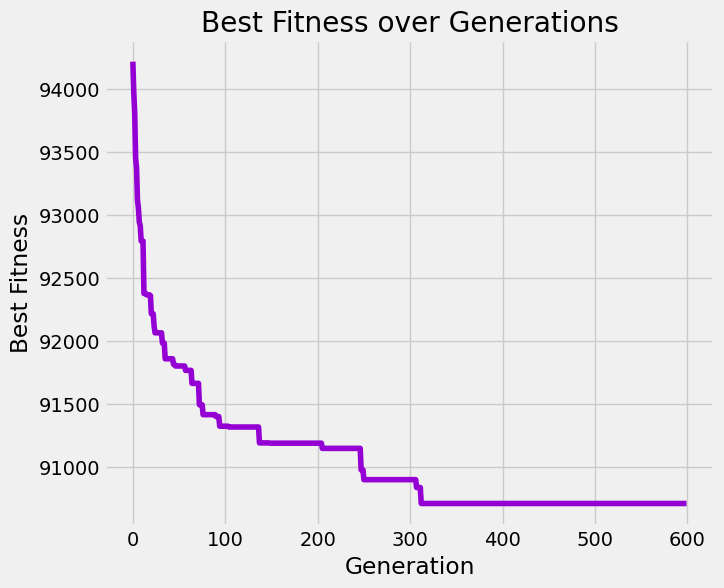

In [185]:
class GeneticAlgorithm:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.pop_size = pop_size
        self.tasks = tasks
        self.max_iter = max_iter
        self.mutation_rate = 0.1
        self.population = common_initial_population.copy()
        self.best_individual = None
        self.best_fitness = float('inf')
        self.avg_fitness = []
        self.best_fitnesses = []

    def evaluate_population(self):
        fitness_values = np.zeros(len(self.population))
        for i in range(len(self.population)):
            fitness_values[i] = self.cost_func(self.population[i])
        return fitness_values

    def tournament_selection(self, fitness_values, k=10):
        selected_indices = np.random.choice(self.pop_size, k, replace=False)
        best_index = selected_indices[np.argmin(fitness_values[selected_indices])]
        return self.population[best_index]

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, self.tasks)
        return np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))

    def mutate(self, individual):  # Exploitation by [-1, +1]
        for i in range(self.tasks):
            if len(connections[i]['fns'])>0 and np.random.rand() < self.mutation_rate:
                if individual[i] <= 0 :
                    individual[i] += 1;
                elif individual[i]>= len(connections[i]['fns']) - 1:
                    individual[i] += -1
                else :
                    individual[i] += np.random.choice([-1, 1])
        return individual

    def evolve(self):
        fitness_values = self.evaluate_population()
        best_idx = np.argmin(fitness_values)
        best_fitness = fitness_values[best_idx]
        if best_fitness < self.best_fitness:
            self.best_fitness = best_fitness
            self.best_individual = self.population[best_idx]
        self.best_fitnesses.append(self.best_fitness)

        new_population = []
        while len(new_population) < self.pop_size:
            parent1 = self.tournament_selection(fitness_values)
            parent2 = self.tournament_selection(fitness_values)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)

        # Evaluate and sort new population by fitness for survivor selection
        indexed_fitness = [(ind, self.cost_func(ind)) for ind in new_population]
        indexed_fitness.sort(key=lambda x: x[1])
        self.population = [x[0] for x in indexed_fitness[:self.pop_size]]

    def start(self):
        for _ in range(self.max_iter):
            self.evolve()
        plt.figure(figsize=(7, 6))
        plt.plot(self.best_fitnesses, color='darkviolet')
        plt.title('Best Fitness over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.show()

ga = GeneticAlgorithm(pop_size = 100, tasks = num_tasks, max_iter = 600)
ga.cost_func = fitness_func
ga.start()

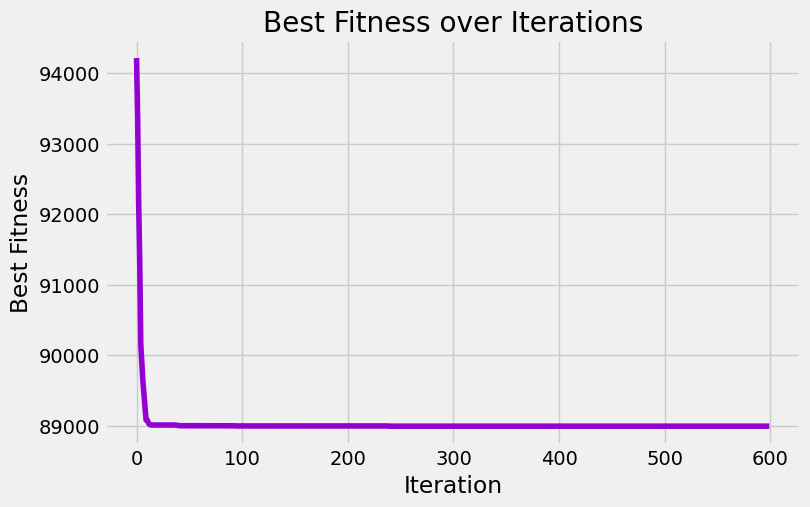

In [186]:
class JayaAlgorithm:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.pop_size = pop_size
        self.tasks = tasks
        self.max_iter = max_iter
        self.population = common_initial_population.copy()
        self.best_fitnesses = []

    def find_best_and_worst(self):
        fitness_values = np.array([self.cost_func(individual) for individual in self.population])
        best_idx = np.argmin(fitness_values)
        worst_idx = np.argmax(fitness_values)
        return best_idx, worst_idx

    def evolve(self):
        for _ in range(self.max_iter):
            best_idx, worst_idx = self.find_best_and_worst()
            best_solution = self.population[best_idx]
            worst_solution = self.population[worst_idx]
            
            for i in range(self.pop_size):
                if i != best_idx and i != worst_idx:
                    new_solution = self.population[i].copy()
                    for j in range(self.tasks):
                        r1, r2 = np.random.random(), np.random.random()
                        # Move towards best, away from worst
                        new_solution[j] = new_solution[j] + \
                                          r1 * (best_solution[j] - abs(new_solution[j])) - \
                                          r2 * (worst_solution[j] - abs(new_solution[j]))
                        # Ensure new solution does not go out of bounds (if applicable)
                        if connections[j]['fns']:
                            new_solution[j] = np.clip(new_solution[j], 0, len(connections[j]['fns']) - 1)
                    
                    # Update if the new solution is better
                    if self.cost_func(new_solution) < self.cost_func(self.population[i]):
                        self.population[i] = new_solution

            # Update the best fitness found so far
            self.best_fitnesses.append(self.cost_func(best_solution))

    def start(self):
        self.evolve()
        plt.figure(figsize=(8, 5))
        plt.plot(self.best_fitnesses, color='darkviolet')
        plt.title('Best Fitness over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.show()

jaya = JayaAlgorithm(pop_size=100, tasks=num_tasks, max_iter=600)
jaya.cost_func = fitness_func
jaya.start()

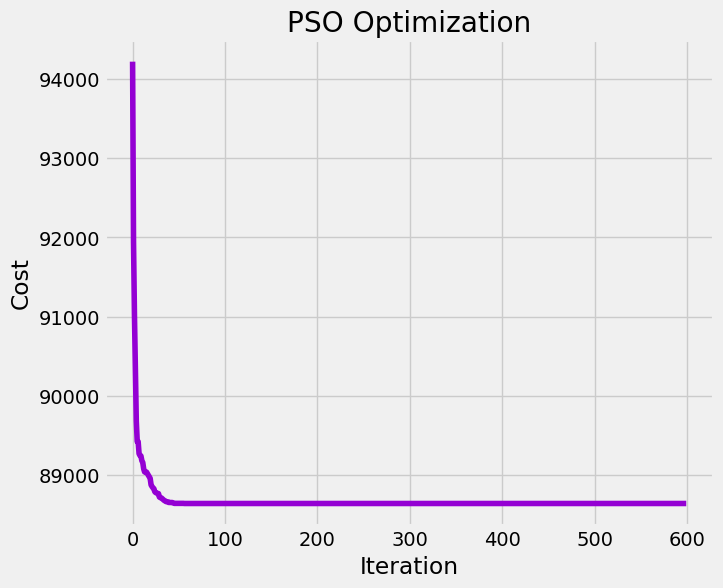

In [187]:
class PSO:
    def __init__(self, pop_size, tasks, max_iter):
        self.cost_func = None
        self.w = 0.5  # Inertia weight
        self.c1 = 1.5  # Cognitive weight
        self.c2 = 1.5  # Social weight
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.tasks = tasks
        
        self.positions = []
        self.velocities = []
        self.personal_best = []
        self.global_best = None
        self.global_best_cost = float('inf')
        
        self.costs = []
    def generate_initial_pop(self):
        for i in range(self.pop_size):
            position = common_initial_population[i].copy()
            self.positions.append(position)
            self.personal_best.append(position)
            if self.global_best_cost == None or self.evaluate(position)<self.global_best_cost :
                    self.global_best = position
                    self.global_best_cost = self.evaluate(position)
            self.velocities.append(random.randint(-len(connections[j]['fns'])+1, len(connections[j]['fns'])-1))
    
    def evaluate(self, position):
        return self.cost_func(position)  

    def update_velocity(self, _iter):
        # Dynamic adjustment of inertia weight based on the iteration
        if _iter < self.max_iter // 3:
            self.w = 0.5
        elif _iter < 2 * self.max_iter // 3:
            self.w = 0.3
        else:
            self.w = 0.1
        for i in range(self.pop_size):
            r1, r2 = np.random.random(), np.random.random()
            cognitive = self.c1 * r1 * (np.array(self.personal_best[i]) - np.array(self.positions[i]))
            social = self.c2 * r2 * (np.array(self.global_best) - np.array(self.positions[i]))
            self.velocities[i] = self.w * np.array(self.velocities[i]) + cognitive + social

    def update_position(self):
        for i in range(self.pop_size):
            self.positions[i] = np.array(self.positions[i]) + np.array(self.velocities[i])
            self.positions[i] = np.clip(self.positions[i], 0, len(connections[0]['fns']) - 1).astype(int)

    def update_personal_best_and_gbest(self):
        for i in range(self.pop_size):
            cost = self.evaluate(self.positions[i])
            if cost < self.evaluate(self.personal_best[i]):
                self.personal_best[i] = self.positions[i].copy()
                if cost < self.global_best_cost:
                    self.global_best = self.positions[i].copy()
                    self.global_best_cost = cost

    def start(self):
        self.generate_initial_pop()
        for _iter in range(self.max_iter):
            self.costs.append(self.global_best_cost)
            self.update_velocity(_iter)
            self.update_position()
            self.update_personal_best_and_gbest()
        
        plt.figure(figsize=(7, 6))
        plt.plot(self.costs, color='darkviolet')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title('PSO Optimization')
        plt.show()

pso = PSO(pop_size=100, tasks=num_tasks, max_iter=600)
pso.cost_func = fitness_func
pso.start()

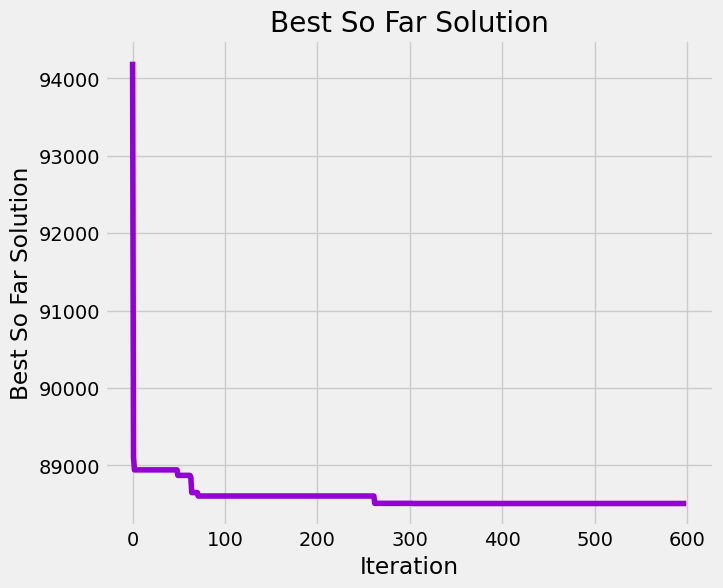

In [188]:
class GSA:
    def __init__(self, pop_size=1, tasks=1, max_iter=100):
        self.cost_func = None
        self.alpha = 0.1
        self.G = 10000
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.tasks = tasks
        self.best_so_far = None
        self.best_fitnesses=[]

        self.X = np.array(common_initial_population, dtype=float)
        self.V = np.random.rand(pop_size, tasks)
        self.f = np.full((pop_size, tasks), None)  # None  # Will become a list inside cal_f
        self.a = np.full((pop_size, tasks), None)
        self.q = np.full((pop_size, 1), None)
        self.M = np.full((pop_size, 1), None)
        self.cost_matrix = np.full((pop_size, 1), None)
        self.max_delay = None
        self.avg_delay = None

    # Evaluate a single x (x_i)
    def evaluate(self, args):
        return self.cost_func(args)
    
    # Generate the cost of all particles
    def gen_cost_matrix(self):
        for i, x in enumerate(self.X):
            self.cost_matrix[i] = self.evaluate(x)

    def cal_q(self):
        best = np.min(self.cost_matrix)
        worst = np.max(self.cost_matrix)
        std_dev = np.std(self.cost_matrix)
    
        # Dynamic threshold based on a fraction of the standard deviation
        threshold = 0.1 * std_dev
    
        if worst - best < threshold or std_dev < 1e-6:  # Adjust 1e-6 as needed for your scale
            self.q = np.ones(self.pop_size)  # Uniform quality if no significant range
        else:
            # Invert the fitness so that lower costs result in higher quality
            self.q = (worst - self.cost_matrix) / (worst - best)
            self.q += 0.01

    def cal_m(self):
        self.M = self.q / np.sum(self.q)

    def cal_a(self):
        for i in range(self.pop_size):
            self.a[i] = self.f[i] / self.M[i] 

    def cal_v(self, _iter):
        # Reduce velocity influence over time to allow finer control as solutions improve
        damping_factor = 1 - 0.5 *(_iter / self.max_iter)
        self.V =  (np.random.uniform(0, 0.8) * self.V) + self.a
        
    def move(self):
        self.X = self.X + self.V
        for i in range(self.pop_size):
            for j in range(self.tasks):
                if self.X[i][j] < 0:
                    self.X[i][j] = len(connections[j]['fns'])-1
                elif self.X[i][j] >= len(connections[j]['fns']):
                    self.X[i][j] = 0 
        self.X = np.array(self.X, dtype=float)

    def cal_f(self):
        costs = self.cost_matrix.copy()
        costs.sort(axis=0)

        for i in range(self.pop_size):
            f = None
            for cost in costs:
                tmp = np.where(self.cost_matrix == cost)[0]
                j = tmp[0]
                dividend = float(self.M[i][0] * self.M[j][0])
                divisor = np.sqrt(np.sum((self.X[i] - self.X[j]) ** 2)) + np.finfo('float').eps
                if f is None:
                    f = self.G * (dividend / divisor) * (self.X[j] - self.X[i])
                else:
                    f = f + self.G * (dividend / divisor) * (self.X[j] - self.X[i])
            self.f[i] = np.random.uniform(0, 0.5) * f

    def update_g(self, iteration):
        self.G = self.G * np.e ** (- self.alpha * (iteration / self.max_iter))

    def update_best_so_far(self):
        for x in self.X:
          if self.best_so_far is None or self.evaluate(self.best_so_far) > self.evaluate(x):
              self.best_so_far=x
              
    def integrate_best_solution(self, _iter):
        if _iter % 10 == 0:  # Every 10 iterations
            # Replace a randomly selected particle with the best-so-far particle
            idx = np.random.randint(0, self.pop_size)
            self.X[idx] = self.best_so_far.copy()     

    def start(self):
        _iter = 0
        avg = []
        bsf = []
        while _iter < self.max_iter:
            self.gen_cost_matrix()
            self.update_best_so_far()
            avg.append(sum(self.cost_matrix) / len(self.cost_matrix))
            bsf.append(self.evaluate(self.best_so_far))
            
            self.gen_cost_matrix()
            self.cal_q()
            self.cal_m()
            self.update_g(_iter)
            self.cal_f()
            self.cal_a()
            self.cal_v(_iter)
            self.move()
            self.update_best_so_far()
            self.integrate_best_solution(_iter)

            _iter += 1
        else:
            plt.figure(figsize=(7, 6))  # Create a figure with a specific size
            plt.plot(bsf, color='darkviolet')
            plt.title('Best So Far Solution')
            plt.xlabel('Iteration')
            plt.ylabel('Best So Far Solution')
            plt.show()
        self.best_fitnesses=bsf

gsa = GSA(pop_size=100, tasks=num_tasks, max_iter=600)
gsa.cost_func = fitness_func
gsa.start()

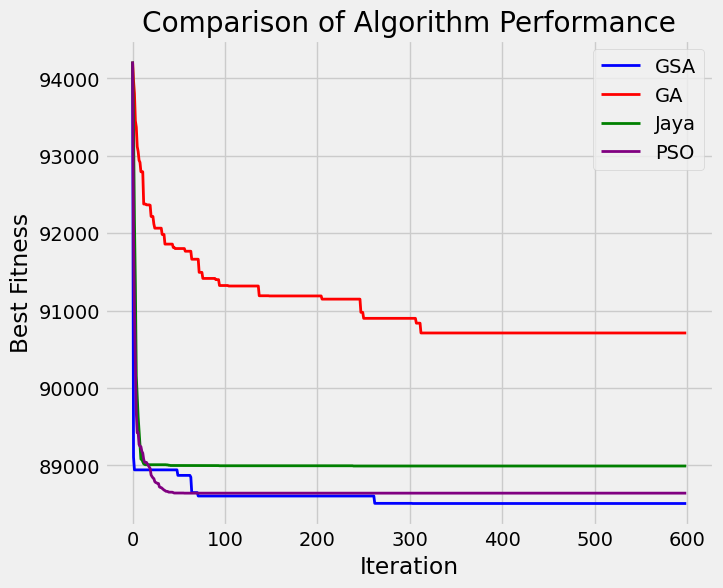

In [189]:
# Collecting fitnesses
all_fitness_gsa = gsa.best_fitnesses
all_fitness_ga = ga.best_fitnesses
all_fitness_jaya = jaya.best_fitnesses
all_fitness_pso = pso.costs

# Combined plotting
plt.figure(figsize=(7, 6))  # Adjusted size for better readability
plt.plot(all_fitness_gsa, label='GSA', color='blue', linewidth=2)
plt.plot(all_fitness_ga, label='GA', color='red',  linewidth=2)
plt.plot(all_fitness_jaya, label='Jaya', color='green', linewidth=2)
plt.plot(all_fitness_pso, label='PSO', color='purple', linewidth=2)
plt.title('Comparison of Algorithm Performance')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(facecolor='white')
ax=plt.axes()
ax.set_facecolor("white")
fns = np.array([100, 150, 200, 250])
eu2000 = np.array([144.88521818669324, 146.06725206162955, 145.22425324823445, 147.0944319462382])
eu3000 = np.array([146.1333805900228, 149.11131576904023, 146.82895900570546, 149.68006959722175])
eu5000 = np.array([156.02282726597792, 157.46426469279453, 155.81313531409026, 157.2445276467267])
# first plot with X and Y data
plt.plot(fns, eu2000, label="EUs=2000", marker='o', markerfacecolor='black', markersize=12)
plt.plot(fns, eu3000, label="EUs=3000", marker='s', markerfacecolor='black', markersize=10)
plt.plot(fns, eu5000, label="EUs=5000", marker='^', markerfacecolor='black', markersize=12, color='purple')

plt.xlabel("Number of fog nodes")
plt.ylabel("Average delay")
plt.title('Average delay with variation in different EU and FN')
plt.legend()

for x, y in zip(fns, eu2000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

for x, y in zip(fns, eu3000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

for x, y in zip(fns, eu5000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

plt.ylim(140, 165)
plt.show()

In [ ]:
fcfs_connections = {}

for i in range(num_tasks):
    task = sdn.fcfs_queue.get()[1]
    allowed_delay = task.deadline-task.gen_time
    task.queue_pos = i+1
    fcfs_connections[i] = {}
    fcfs_connections[i]['task_id'] = task.id
    fcfs_connections[i]['fns'] = []
    qd = computeQueueingDelay(task, sdn)
    for fn in sdn.list_of_fns:
        if(fn.failrate > 0.05):
          pass
        od = computeOffloadingDelay(task, fn)
        td = computeTransmissionDelay(task, fn)
        total_delay = qd + od + td
        if(total_delay <= allowed_delay):
          fcfs_connections[i]['fns'].append(fn.id)


# for item in fcfs_connections.items():
#   print(item)

In [ ]:
sjf_connections = {}

for i in range(num_tasks):
    task = sdn.sjf_queue.get()[1]
    allowed_delay = task.deadline-task.gen_time
    task.queue_pos = i+1
    sjf_connections[i] = {}
    sjf_connections[i]['task_id'] = task.id
    sjf_connections[i]['fns'] = []
    qd = computeQueueingDelay(task, sdn)
    for fn in sdn.list_of_fns:
        if(fn.failrate > 0.05):
          pass
        od = computeOffloadingDelay(task, fn)
        td = computeTransmissionDelay(task, fn)
        total_delay = qd + od + td
        # print("qd " + str(qd))
        # print("od " + str(od))
        # print("td " + str(td))
        # print("total " + str(total_delay))
        if(total_delay <= allowed_delay):
          sjf_connections[i]['fns'].append(fn.id)


# for item in sjf_connections.items():
#     print(item)

In [ ]:
labels = [100, 200, 300]
unassigned = [16, 30, 65]
sjf_unassigned = [89, 170, 251]
fcfs_unassigned = [42, 85, 137]


# cnt = 0
# fcfs_cnt = 0
# sjf_cnt = 0
# i = 0

# for j in range(len(connections)):
#     if len(connections[j]['fns']) == 0:
#         cnt = cnt + 1
#     if len(fcfs_connections[j]['fns']) == 0:
#         fcfs_cnt = fcfs_cnt + 1
#     if len(sjf_connections[j]['fns']) == 0:
#         sjf_cnt = sjf_cnt + 1

#     if labels[i]== j+1 :
#         unassigned.append(cnt)
#         fcfs_unassigned.append(fcfs_cnt)
#         sjf_unassigned.append(sjf_cnt)
#         i = i + 1

# print(unassigned)
# print(fcfs_unassigned)
# print(sjf_unassigned)

In [ ]:

index = np.arange(len(labels))
bar_width = 0.25


fig, ax = plt.subplots()
fig.set_facecolor("white")
ax.set_facecolor("white")
our_algo = ax.bar(index, unassigned, bar_width, label="Our Algorithm")

sjf = ax.bar(index+ bar_width, sjf_unassigned, bar_width, label="SJF")

fcfs = ax.bar(index+ 2*bar_width, fcfs_unassigned, bar_width, label="FCFS", color='purple')

ax.set_xlabel('Number of tasks taken')
ax.set_ylabel('Number of unassigned tasks')
ax.set_title('Number of unassigned tasks per tasks taken')

ax.set_xticks(index + bar_width)
ax.set_xticklabels(labels)
ax.legend()

for p in our_algo:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

for p in sjf:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

for p in fcfs:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.ylim(0, 300)

plt.show()

In [ ]:
a = np.array([156.19637530578578, 160.56561147850962, 156.43220000918475, 163.10769981595885, 147.63476955400046, 156.66552333199596, 160.10951403165146])
print(np.average(a))